### Documentation

#### 1.How did you decide to handle this amount of data

Uploading csvs in pandas DataFrame. Text extraction using BeautifulSoap.


#### 2.How did you decide to do feature engineering 

I've decided to make vocabulary by words from keyword2tumor_type.csv as they are already related to targets. And then I've created a tf/idf embedding. 

#### 3.How did you decide which models to try (if you decide to train any models)

As we have a classification problem. Firstly, I've decided to use simple logistic regression to fastly test the results. After I made sure it works I've decided to use 2 state of the art models: random forest and gradient boosting.

#### 4.How did you perform validation of your model

Using KFolf from sklearn. And after extraction the best training subset I've tuned the parameters of the models also on a validation.

#### 5.What metrics did you measure
Weighted recision, recall, F1 as we have imbalanced classes. If there is more data I'd also use roc-auc.

#### 6.How do you expect your model to perform on test data (in terms of your metrics)

On validation.


#### 7.How fast will your algorithm performs and how could you improve its performance if you would have more time

From the report it's few seconds now. As more data we have as more time it will take. To improve it I'd prefer to use parallel techniques, batch iteration and fitting on GPUs.

#### 8.How do you think you would be able to improve your algorithm if you would have more data

Extracting more relevant words to use in vocabulary. With bigger dimension it would be computationally harder to use tf/idf so it may be replaced by other embeddings such as word2vec. Also as you may see below I've used both training and testing data to create tf/idf embedding. With more data it will not be necessary to refit the model each time beacause the idf coeficcient will converge to the probability (as it uses the amounts of documents) and it we will only need to compute tfs for new docs.

#### 9.What potential issues do you see with your algorithm
A small amount of data. It's hard to find patterns for algorithm. It should also be better features extracting: try to find new relevant words that are not in keyword2tumor_type.csv .

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict, OrderedDict
import matplotlib.pyplot as plt
import scipy as sp
import re

from bs4 import BeautifulSoup
import requests

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer 

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

import warnings
warnings.filterwarnings('ignore')

In [2]:
train_df = pd.read_csv('Desktop/train.csv')
keywords_df = pd.read_csv('Desktop/keyword2tumor_type.csv')
test_df = pd.read_csv('Desktop/test.csv')

In [3]:
print(train_df['url'].shape)
train_df.head(5)

(100,)


,url,doc_id,label
0,http://elbe-elster-klinikum.de/fachbereiche/ch...,1,1
1,http://klinikum-bayreuth.de/einrichtungen/zent...,3,3
2,http://klinikum-braunschweig.de/info.php/?id_o...,4,1
3,http://klinikum-braunschweig.de/info.php/?id_o...,5,1
4,http://klinikum-braunschweig.de/zuweiser/tumor...,6,3


In [4]:
print(test_df['url'].shape)
test_df.head(5)

(48,)


,url,doc_id
0,http://chirurgie-goettingen.de/medizinische-ve...,0
1,http://evkb.de/kliniken-zentren/chirurgie/allg...,2
2,http://krebszentrum.kreiskliniken-reutlingen.d...,7
3,http://marienhospital-buer.de/mhb-av-chirurgie...,15
4,http://marienhospital-buer.de/mhb-av-chirurgie...,16


In [5]:
keywords_df.head(5)

,keyword,tumor_type
0,senologische,Brust
1,brustzentrum,Brust
2,breast,Brust
3,thorax,Brust
4,thorakale,Brust


### Analysis

In [6]:
data_per_label_dict = {1:0, 2:0, 3:0}
for label in train_df['label']:
    data_per_label_dict[label]+=1

{1: 32, 2: 59, 3: 9}


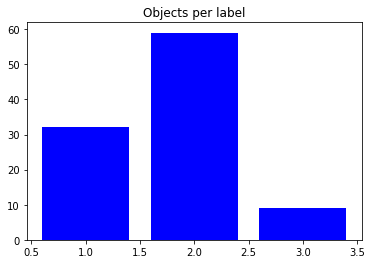

In [7]:
plt.bar(data_per_label_dict.keys(), data_per_label_dict.values(), align='center', alpha=1, color = 'blue')
plt.title('Objects per label')
print(data_per_label_dict)

#### => classes are imbalanced

In [8]:
print("Dictionary lenght: ", len(keywords_df['keyword']))

Dictionary lenght:  126


### Preprocessing

In [22]:
data_X = []
data_y = []

In [27]:
stop_words = set(stopwords.words('german'))   
stop_words.add('javascript')
lemmatizer = WordNetLemmatizer()

vocab = set(keywords_df['keyword'])
diction = []
for phrase in vocab:
    for word in phrase.split(' '):
        word.replace('-','')
        if len(word) > 2:
            diction.append(lemmatizer.lemmatize(word))

def preprocess(ind, url, is_train = True):
    if ind == 85:
        return 
    r  = requests.get(url)
    data = r.text
    soup = BeautifulSoup(data, "lxml")
    
    tags = soup.find_all('p')
    text = ''.join(tag.text + ' ' for tag in tags)
    
    text = text.lower()
    text = re.sub(r'[0-9]+', '', text)
    text = re.sub('\W+',' ', text)
    text = re.sub(r'_',' ', text)
    text = text.strip()
    
    words = word_tokenize(text)
    tokens_no_stpwrd = [i for i in words if not i in stop_words and len(i) > 2]
    tokens = [lemmatizer.lemmatize(t) for t in tokens_no_stpwrd]
    
    result_tokens = [token for token in tokens if token in diction]
    
    result_text = ''.join(token + ' ' for token in result_tokens)
    
    if len(result_text) != 0:
        data_X.append(result_text)
        if is_train:
            data_y.append(train_df['label'][ind])
        else:
            test_y_id.append(test_df['doc_id'][ind])

In [24]:
for ind,url in enumerate(train_df['url']):
    preprocess(ind, url)

In [25]:
train_X = data_X
train_y = data_y
data_X = []
test_y_id = []

In [28]:
for ind,url in enumerate(test_df['url']):
    preprocess(ind, url, False)

In [29]:
test_X = data_X

In [37]:
data_for_vocab = train_X + test_X

In [50]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(data_for_vocab)

In [51]:
X = X.toarray()
train_X = X[:len(train_X)]
test_X = X[len(train_X):]

In [62]:
train_y = np.asarray(train_y)

### Logistic Regression

In [64]:
clf_log_reg = LogisticRegression()
kf = KFold(n_splits=5)
best_f1 = -1
f1_l = []
pr_l = []
rec_l = []

for train_ind, test_ind in kf.split(train_X,train_y):
    clf_log_reg.fit(train_X[train_ind], train_y[train_ind])
    predictions = clf_log_reg.predict(train_X[test_ind])
    
    f1 = f1_score(train_y[test_ind],predictions, average='weighted')
    f1_l.append(f1)
    pr = precision_score(train_y[test_ind],predictions, average='weighted')
    pr_l.append(pr)
    rec = recall_score(train_y[test_ind],predictions, average='weighted')
    rec_l.append(rec)
    if f1 > best_f1:
        best_f1 = max(best_f1, f1)
        best_X_train = train_X[train_ind]
        best_y_train = train_y[train_ind]
        best_X_test = train_X[test_ind]
        best_y_test = train_y[test_ind]

In [65]:
print("F1 vallidation:        ", f1_l)
print("Precision vallidation: ", pr_l)
print("Recall vallidation:    ", rec_l)
print("Best F1: ", best_f1)

F1 vallidation:         [0.4688644688644689, 0.4688644688644689, 0.6688963210702342, 0.4688644688644689, 0.5333333333333333]
Precision vallidation:  [0.37869822485207105, 0.37869822485207105, 0.591715976331361, 0.37869822485207105, 0.4444444444444444]
Recall vallidation:     [0.6153846153846154, 0.6153846153846154, 0.7692307692307693, 0.6153846153846154, 0.6666666666666666]
Best F1:  0.6688963210702342


### Random Forest

In [67]:
clf_rndm_forest = RandomForestClassifier(max_depth=3)
kf = KFold(n_splits=5)
best_f1 = -1
f1_l = []
pr_l = []
rec_l = []

for train_ind, test_ind in kf.split(train_X,train_y):
    clf_rndm_forest.fit(train_X[train_ind], train_y[train_ind])
    predictions = clf_rndm_forest.predict(train_X[test_ind])
    
    f1 = f1_score(train_y[test_ind],predictions, average='weighted')
    f1_l.append(f1)
    pr = precision_score(train_y[test_ind],predictions, average='weighted')
    pr_l.append(pr)
    rec = recall_score(train_y[test_ind],predictions, average='weighted')
    rec_l.append(rec)
    if f1 > best_f1:
        best_f1 = max(best_f1, f1)
        best_X_train = train_X[train_ind]
        best_y_train = train_y[train_ind]
        best_X_test = train_X[test_ind]
        best_y_test = train_y[test_ind]

In [68]:
print("F1 vallidation:        ", f1_l)
print("Precision vallidation: ", pr_l)
print("Recall vallidation:    ", rec_l)
print("Best F1: ", best_f1)

F1 vallidation:         [0.4688644688644689, 0.4688644688644689, 0.6688963210702342, 0.4688644688644689, 0.5333333333333333]
Precision vallidation:  [0.37869822485207105, 0.37869822485207105, 0.591715976331361, 0.37869822485207105, 0.4444444444444444]
Recall vallidation:     [0.6153846153846154, 0.6153846153846154, 0.7692307692307693, 0.6153846153846154, 0.6666666666666666]
Best F1:  0.6688963210702342


### Random Forest Tuning

In [78]:
parameters = {'max_depth':[2,3,4,5]}
clf = GridSearchCV(RandomForestClassifier(), parameters, scoring = 'f1_weighted', cv=5)
clf.fit(train_X, train_y)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': [2, 3, 4, 5]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='f1_weighted',
       verbose=0)

In [83]:
clf.cv_results_

{'mean_fit_time': array([0.01097088, 0.00850983, 0.00937343, 0.00937281]),
 'std_fit_time': array([0.00274967, 0.00501254, 0.00765337, 0.00765286]),
 'mean_score_time': array([0.00159497, 0.00077329, 0.00312381, 0.00312409]),
 'std_score_time': array([0.00048819, 0.00070784, 0.00624762, 0.00624819]),
 'param_max_depth': masked_array(data=[2, 3, 4, 5],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'max_depth': 2},
  {'max_depth': 3},
  {'max_depth': 4},
  {'max_depth': 5}],
 'split0_test_score': array([0.50310559, 0.50310559, 0.50310559, 0.50310559]),
 'split1_test_score': array([0.62121212, 0.50310559, 0.63311688, 0.46753247]),
 'split2_test_score': array([0.46886447, 0.46886447, 0.49230769, 0.60769231]),
 'split3_test_score': array([0.53333333, 0.53333333, 0.53333333, 0.53333333]),
 'split4_test_score': array([0.61244019, 0.61244019, 0.61244019, 0.61244019]),
 'mean_test_score': array([0.54644575, 0.52060995, 0.553811

In [84]:
print(clf.best_params_)
print(clf.best_score_)

{'max_depth': 4}
0.5538118239026419


In [88]:
clf_tree_best = RandomForestClassifier(max_depth=4, random_state=42)
clf_tree_best.fit(best_X_train, best_y_train)
predictions = clf_tree_best.predict(best_X_test)
f1_score(best_y_test,predictions, average='weighted')

0.8018648018648018

### Boosting

In [89]:
clf_boost = GradientBoostingClassifier()
kf = KFold(n_splits=5)
best_f1 = -1
f1_l = []
pr_l = []
rec_l = []

for train_ind, test_ind in kf.split(train_X,train_y):
    clf_boost.fit(train_X[train_ind], train_y[train_ind])
    predictions = clf_boost.predict(train_X[test_ind])
    
    f1 = f1_score(train_y[test_ind],predictions, average='weighted')
    f1_l.append(f1)
    pr = precision_score(train_y[test_ind],predictions, average='weighted')
    pr_l.append(pr)
    rec = recall_score(train_y[test_ind],predictions, average='weighted')
    rec_l.append(rec)
    if f1 > best_f1:
        best_f1 = max(best_f1, f1)
        best_X_train = train_X[train_ind]
        best_y_train = train_y[train_ind]
        best_X_test = train_X[test_ind]
        best_y_test = train_y[test_ind]

In [90]:
print("F1 vallidation:        ", f1_l)
print("Precision vallidation: ", pr_l)
print("Recall vallidation:    ", rec_l)
print("Best F1: ", best_f1)

F1 vallidation:         [0.6720647773279352, 0.5538461538461539, 0.6308985132514544, 0.4688644688644689, 0.49122807017543857]
Precision vallidation:  [0.6013986013986015, 0.5934065934065934, 0.7208791208791209, 0.37869822485207105, 0.42424242424242425]
Recall vallidation:     [0.7692307692307693, 0.5384615384615384, 0.6153846153846154, 0.6153846153846154, 0.5833333333333334]
Best F1:  0.6720647773279352


### Gradient Boosting Tuning

In [119]:
parameters={'learning_rate':[0.01, 0.05, 0.1, 0.2],'n_estimators':[100, 150, 200]}
clf = GridSearchCV(GradientBoostingClassifier(), parameters, scoring = 'f1_weighted', cv=5)
clf.fit(train_X, train_y)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sampl...      subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.2], 'n_estimators': [100, 150, 200]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_weighted', verbose=0)

In [120]:
print(clf.best_params_)
print(clf.best_score_)

{'learning_rate': 0.2, 'n_estimators': 150}
0.6228738205808639


In [148]:
clf_boost_best = GradientBoostingClassifier(learning_rate=0.2,n_estimators=150, random_state=42)

In [149]:
clf_boost_best.fit(best_X_train, best_y_train)
predictions = clf_boost_best.predict(best_X_test)
f1_score(best_y_test,predictions, average='weighted')

0.6720647773279352

### Test

In [151]:
submission_df = pd.DataFrame(columns=['doc_id', 'prediction'])

In [152]:
submission_df['doc_id'] = test_df['doc_id']

In [153]:
for ind,val in enumerate(submission_df['doc_id']):
    if val not in test_y_id:
        submission_df['prediction'][ind] = 1

In [157]:
sub_predictions = clf_tree_best.predict(test_X)

In [161]:
dict_id_to_pred = {val:sub_predictions[ind] for ind,val in enumerate(test_y_id)}

In [166]:
for ind,val in enumerate(submission_df['prediction']):
    if val is np.NaN:
        submission_df['prediction'][ind] = dict_id_to_pred[submission_df['doc_id'][ind]]

In [172]:
 submission_df.to_csv('Desktop/submission.csv', index=False) 

In [171]:
submission_df

,doc_id,prediction
0,0,2
1,2,2
2,7,1
3,15,1
4,16,2
5,24,2
6,31,2
7,32,2
8,36,1
9,38,2
